# 频繁模式与关联规则挖掘

In [1]:
import json
import pandas as pd
import numpy as np
import pyfpgrowth
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid") #这是seaborn默认的风格
pd.set_option('precision',3) #设置数据精度

%matplotlib inline

## 0 数据读取
首先读取数据，并展示数据的基本特征。我们选用[Wine Reviews](https://www.kaggle.com/datasets/zynicide/wine-reviews)数据集进行分析

In [2]:
data_csv = "/home/wxz/codes/datasets/Wine Reviews/winemag-data-130k-v2.csv"
data = pd.read_csv(data_csv,index_col=0)
data.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


下面是数据集各个字段的属性信息。这里注意几个关键字段的意义，我们在后续的分析中将重点考虑这几个字段。

* points：评分
* price：价格
* variety：葡萄种类
* country：产地所属国家
* winery：酒厂名称
* taster_name：品酒师

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 13.9+ MB


## 1 数据预处理
我们主要关注points、price、variety、country、winery、taster_name字段的属性，并对其进行分析。首先我们保留这些字段，剔除不需要的字段内容。

In [4]:
# 剔除不需要的字段
wine = data.copy()
wine.drop('points',axis=1,inplace=True)
wine.drop('price',axis=1,inplace=True)
wine.drop('description',axis=1,inplace=True)
wine.drop('designation',axis=1,inplace=True)
wine.drop('province',axis=1,inplace=True)
wine.drop('region_1',axis=1,inplace=True)
wine.drop('region_2',axis=1,inplace=True)
wine.drop('taster_twitter_handle',axis=1,inplace=True)
wine.drop('title',axis=1,inplace=True)
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129971 entries, 0 to 129970
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      129908 non-null  object
 1   taster_name  103727 non-null  object
 2   variety      129970 non-null  object
 3   winery       129971 non-null  object
dtypes: object(4)
memory usage: 5.0+ MB


根据上表可以看到，数据中仍然存在大量的缺失数据，我们需要对缺失数据进行处理。为了防止缺失数据处理可能对数据统计分布造成的偏差，采用将存在数据缺失的行直接剔除的方法进行处理。

In [5]:
wine.dropna(inplace=True)
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103664 entries, 0 to 129970
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   country      103664 non-null  object
 1   taster_name  103664 non-null  object
 2   variety      103664 non-null  object
 3   winery       103664 non-null  object
dtypes: object(4)
memory usage: 4.0+ MB


## 2 寻找频繁模式
这里使用pyfpgrowth库进行频繁模式挖掘

In [6]:
# 提取pattern 可以指定pattern的频率阈值
patterns = pyfpgrowth.find_frequent_patterns(np.array(wine), 100)
print(f'patterns number:{len(patterns)}')
# 输出频率前10的patterns
a = sorted(patterns.items(),key=lambda kv: (kv[1],kv[0]),reverse=True)
print(f'top 10 patterns')
for i in a[:10]:
	print(i)

patterns number:644
top 10 patterns
(('US',), 37730)
(('Roger Voss',), 25512)
(('France',), 21828)
(('France', 'Roger Voss'), 18602)
(('Michael Schachner',), 15127)
(('Italy',), 11042)
(('Kerin O’Keefe',), 10776)
(('Italy', 'Kerin O’Keefe'), 10776)
(('Virginie Boone',), 9537)
(('US', 'Virginie Boone'), 9537)


## 3 导出关联规则

In [7]:
def col_name(s):
	s = [s] if isinstance(s, str) else s
	seriesObj = wine.isin(s).any()
	return list(seriesObj[seriesObj].index)

In [8]:
# 提取关联规则
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)
print(f'rules number:{len(rules)}')
# 输出频率前10的关联规则
print(f'top 10 rules')
a = sorted(rules.items(),key=lambda kv: (kv[1][1],kv[0]),reverse=True)
for k,v in a[:10]:
	print(k,'    ',v)
# 输出所属的数据列
# print()
# for k,v in a[:10]:
# 	print(col_name(k), '    ',col_name(v[0]))

rules number:333
top 10 rules
('Wines & Winemakers',)      (('Portugal', 'Roger Voss'), 1.0)
('Viura',)      (('Michael Schachner', 'Spain'), 1.0)
('Virginie Boone', 'Zinfandel')      (('US',), 1.0)
('Virginie Boone',)      (('US',), 1.0)
('Verdicchio',)      (('Italy', 'Kerin O’Keefe'), 1.0)
('Uruguay',)      (('Michael Schachner',), 1.0)
('Undurraga',)      (('Chile', 'Michael Schachner'), 1.0)
('Turbiana',)      (('Italy', 'Kerin O’Keefe'), 1.0)
('Trapiche',)      (('Argentina', 'Michael Schachner'), 1.0)
('Tinto Fino',)      (('Michael Schachner', 'Spain'), 1.0)


我们从上面提取出的关联规则中选取置信度高、中、低的三条数据进行展示。

In [9]:
# 选取的关联关系
rul = {
	('Wines & Winemakers',) : (('Portugal', 'Roger Voss'), 1.0),
	('Chile', 'Merlot')		: (('Michael Schachner',),     0.9754098360655737),
	('Petit Verdot',)		: (('US',),                     0.7887323943661971)
}
# 输出所属的数据列
print("column name:")
for k,v in rul.items():
	print(col_name(k), '    ',col_name(v[0]))


column name:
['winery']      ['country', 'taster_name']
['country', 'variety']      ['taster_name']
['variety']      ['country']


## 4 关联规则评价
我们使用LIFT、卡方值来检验关联规则。下面我们定义几个计算评估指标的函数。

In [10]:
def collect_has_row(data,pattern):
	"""从data中获取 包含 pattern的所有数据行"""
	a = data.copy()
	pattern = [pattern] if isinstance(pattern, str) else pattern
	for p in pattern:
		a = a[a[col_name(p)[0]].str.contains(p)]	# 包含当前值的行
	return a

def collect_not_row(data,pattern):
	"""从data中获取 不包含 pattern的所有数据行"""
	a = data.copy()
	pattern = [pattern] if isinstance(pattern, str) else pattern
	for p in pattern:
		a = a[~a[col_name(p)[0]].str.contains(p)]	# 包含当前值的行
	return a

def lift(data):
	"""lift值计算"""
	n = np.sum(data)
	a,b,c,d = data.reshape(-1)
	return (a * n)/((a+c)*(a+b))

def ch2(data):
	"""卡方值计算"""
	n = np.sum(data)
	a ,b,c,d = data.reshape(-1)
	return n*np.square(a*d-b*c) / ((a+b)*(c+d)*(a+c)*(b+d))


/tmp/ipykernel_4810/2708160128.py:27: RuntimeWarning: overflow encountered in long_scalars
  return n*np.square(a*d-b*c) / ((a+b)*(c+d)*(a+c)*(b+d))


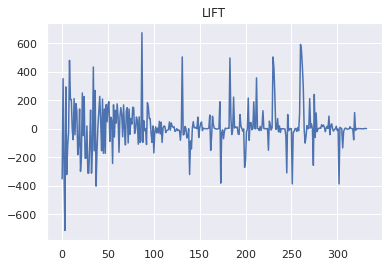

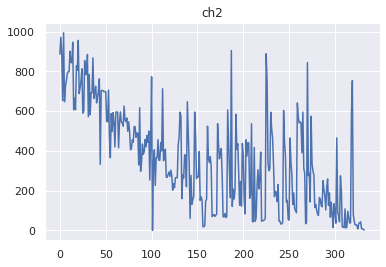

In [11]:
# 计算所有规则的lift值、卡方值并绘制图表
ch2_val = []
lift_val = []
for k,v in rules.items():
	row = collect_has_row(wine,k)	# 包含k的行
	a1 = collect_has_row(row,v[0]).size	# TT
	a2 = row.size - a1				# TF

	row = collect_not_row(wine,v[0]) # 不包含包含k的行
	b1 = collect_has_row(row,k).size	# FT
	b2 = row.size - b1
	a = np.array([[a1,a2],[b1,b2]])
	ch2_val.append(ch2(a))
	lift_val.append(lift(a))

plt.title('LIFT')
plt.plot(range(len(ch2_val)),ch2_val)
plt.show()
plt.title('ch2')
plt.plot(range(len(lift_val)),lift_val)
plt.show()


上图是对所有挖掘出的关联关系进行LIFT值、卡方值计算的结果。对于LIFT值来说，小于1说明它们负相关，大于1说明它们正相关。对于卡方值来说，越大则说明它们之间的相关关系越强。

因此从图中我们可以得到如下结论：

* 对于绝大多数所挖掘到的关联关系，它们的卡方值均非常大，这说明它们之间的关联关系非常强
* 各个规则之间有的呈现正相关，有的呈现负相关，且基本比例相等

此外，我们知道酒的评分和酒的价格之间应该有比较强的相关关系，我们又绘制了如下的表格。

<AxesSubplot:xlabel='points', ylabel='price'>

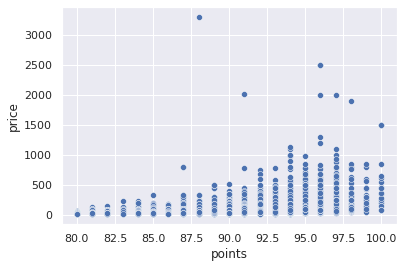

In [12]:
# data.scatterplot(kind='bar',x='points',y='price')
sns.scatterplot(x='points',y='price',data=data)

## 5 结果分析
我们从关联规则中选取一些规则进行分析，并得到它们之间的相关结论

column name:
['winery']      ['country', 'taster_name']
['country', 'variety']      ['taster_name']
['variety']      ['country']


/tmp/ipykernel_4810/2708160128.py:27: RuntimeWarning: overflow encountered in long_scalars
  return n*np.square(a*d-b*c) / ((a+b)*(c+d)*(a+c)*(b+d))


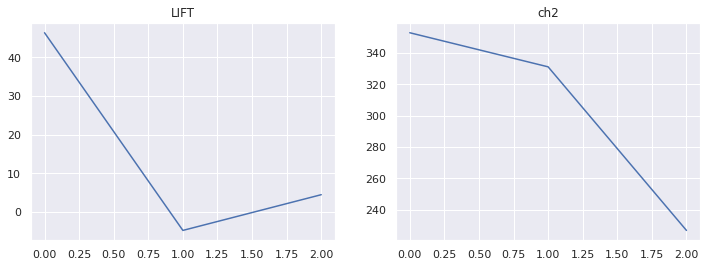

In [13]:
# 选取的关联关系
rules = {
	('Wines & Winemakers',) : (('Portugal', 'Roger Voss'), 1.0),
	('Chile', 'Merlot')		: (('Michael Schachner',),     0.9754098360655737),
	('Petit Verdot',)		: (('US',),                     0.7887323943661971)
}
# 输出所属的数据列
print("column name:")
for k,v in rules.items():
	print(col_name(k), '    ',col_name(v[0]))
# 计算lift、卡方值
ch2_val = []
lift_val = []
for k,v in rules.items():
	row = collect_has_row(wine,k)	# 包含k的行
	a1 = collect_has_row(row,v[0]).size	# TT
	a2 = row.size - a1				# TF

	row = collect_not_row(wine,v[0]) # 不包含包含k的行
	b1 = collect_has_row(row,k).size	# FT
	b2 = row.size - b1
	a = np.array([[a1,a2],[b1,b2]])
	ch2_val.append(ch2(a))
	lift_val.append(lift(a))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('LIFT')
plt.plot(range(len(ch2_val)),ch2_val)

plt.subplot(1,2,2)
plt.title('ch2')
plt.plot(range(len(lift_val)),lift_val)
plt.show()

根据上图的结果，我们相信此三条关联关系的可信度和关联关系。因此我们可以做如下结论：

1. 酒厂：Wines & Winemakers、国家：Portugal、品酒师：Roger Voss，具有很强的关联关系。说明此酒厂很可能位于此国家，而这名品酒师经常为这间酒厂的产品进行品鉴
2. 葡萄：Merlot、国家：Chile、品酒师：Michael Schachner，具有很强的关联关系。说明此Chile适合种种只Merlot葡萄，并且这名品酒师的国籍是Chile
3. 葡萄：Petit Verdot、国家：US，具有很强的关联关系。说明此US适合种植Petit Verdot葡萄。